In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
import numpy as np
from sklearn.preprocessing import StandardScaler

import keras
import keras_tuner as kt

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

import warnings
warnings.filterwarnings('ignore')

# Import Dataset

In [13]:
df = pd.read_csv("CSCO.csv")
df.head(10)

,Date,Open,High,Low,Close,Adj Close,Volume
0,1990-02-16,0.0,0.079861,0.073785,0.077257,0.059806,940636800
1,1990-02-20,0.0,0.079861,0.074653,0.079861,0.061822,151862400
2,1990-02-21,0.0,0.078993,0.075521,0.078125,0.060478,70531200
3,1990-02-22,0.0,0.081597,0.078993,0.078993,0.061150,45216000
4,1990-02-23,0.0,0.079861,0.078125,0.078559,0.060814,44697600
5,1990-02-26,0.0,0.079861,0.076389,0.076389,0.059134,26928000
6,1990-02-27,0.0,0.079427,0.076389,0.078125,0.060478,25574400
7,1990-02-28,0.0,0.082465,0.078125,0.080729,0.062494,67968000
8,1990-03-01,0.0,0.081597,0.079861,0.079861,0.061822,28425600
9,1990-03-02,0.0,0.081597,0.079861,0.080729,0.062494,8438400


In [14]:
df.tail(10)

,Date,Open,High,Low,Close,Adj Close,Volume
7579,2020-03-19,37.049999,39.320000,36.150002,37.709999,37.709999,58319700
7580,2020-03-20,38.270000,38.470001,35.400002,35.599998,35.599998,48582500
7581,2020-03-23,35.509998,35.820000,33.740002,34.599998,34.599998,39823400
7582,2020-03-24,36.410000,38.680000,35.540001,38.599998,38.599998,48235600
7583,2020-03-25,38.650002,39.950001,37.500000,37.669998,37.669998,42873900
7584,2020-03-26,37.970001,40.919998,37.369999,40.580002,40.580002,38473300
7585,2020-03-27,39.209999,40.150002,38.410000,38.820000,38.820000,31278600
7586,2020-03-30,39.450001,40.490002,38.959999,40.320000,40.320000,27120300
7587,2020-03-31,40.130001,40.419998,39.110001,39.310001,39.310001,26014200
7588,2020-04-01,38.169998,38.860001,37.869999,38.330002,38.330002,26773900


# EDA

In [15]:
df.shape

(7589, 7)

The dataset consist of 7 columns and 7,589 records

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7589 entries, 0 to 7588
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       7589 non-null   object 
 1   Open       7589 non-null   float64
 2   High       7589 non-null   float64
 3   Low        7589 non-null   float64
 4   Close      7589 non-null   float64
 5   Adj Close  7589 non-null   float64
 6   Volume     7589 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 415.2+ KB


All variables, except for Date, have numeric data types. The Date variable has a data type of object (string).

### Data Preprocessing

I will do univariate time series prediction using only the Date and Close columns.

In [17]:
df = df[['Date', 'Close']]
df.head()

,Date,Close
0,1990-02-16,0.077257
1,1990-02-20,0.079861
2,1990-02-21,0.078125
3,1990-02-22,0.078993
4,1990-02-23,0.078559


In [18]:
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

df.head(10)

,Close
Date,
1990-02-16,0.077257
1990-02-20,0.079861
1990-02-21,0.078125
1990-02-22,0.078993
1990-02-23,0.078559
1990-02-26,0.076389
1990-02-27,0.078125
1990-02-28,0.080729
1990-03-01,0.079861


Above, I changed the Date datatype to datetime and then set it as the index.

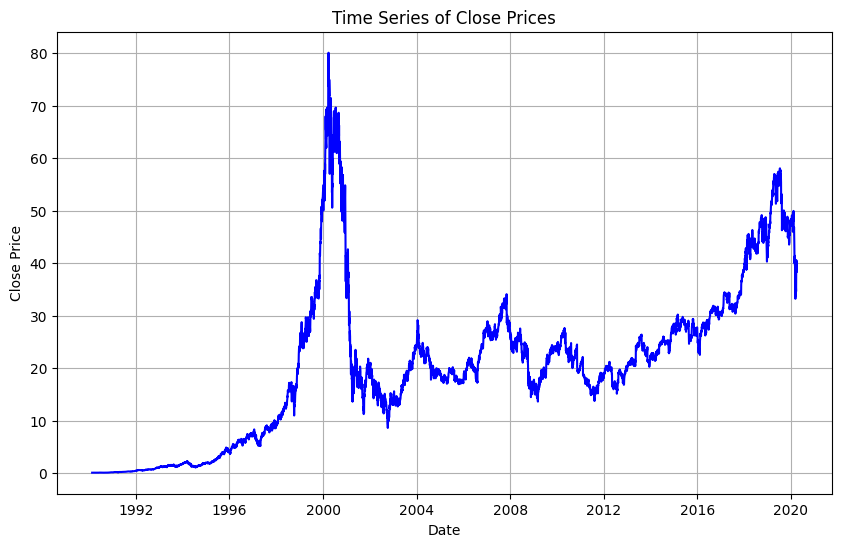

In [19]:
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['Close'], color='b')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Time Series of Close Prices')
plt.grid(True)
plt.show()

The image above shows a graph of the close price over time. It can be seen that the highest close price occurred around the year 2000.

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7589 entries, 1990-02-16 to 2020-04-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   7589 non-null   float64
dtypes: float64(1)
memory usage: 118.6 KB


The data is now univariate, focusing on the single variable "Close."

In [21]:
days = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

for i in range (0, 30):
    day_name = days[df.index[i].weekday()]
    print(f"Tanggal {df.index[i].date()} = {day_name}")

Tanggal 1990-02-16 = Friday
Tanggal 1990-02-20 = Tuesday
Tanggal 1990-02-21 = Wednesday
Tanggal 1990-02-22 = Thursday
Tanggal 1990-02-23 = Friday
Tanggal 1990-02-26 = Monday
Tanggal 1990-02-27 = Tuesday
Tanggal 1990-02-28 = Wednesday
Tanggal 1990-03-01 = Thursday
Tanggal 1990-03-02 = Friday
Tanggal 1990-03-05 = Monday
Tanggal 1990-03-06 = Tuesday
Tanggal 1990-03-07 = Wednesday
Tanggal 1990-03-08 = Thursday
Tanggal 1990-03-09 = Friday
Tanggal 1990-03-12 = Monday
Tanggal 1990-03-13 = Tuesday
Tanggal 1990-03-14 = Wednesday
Tanggal 1990-03-15 = Thursday
Tanggal 1990-03-16 = Friday
Tanggal 1990-03-19 = Monday
Tanggal 1990-03-20 = Tuesday
Tanggal 1990-03-21 = Wednesday
Tanggal 1990-03-22 = Thursday
Tanggal 1990-03-23 = Friday
Tanggal 1990-03-26 = Monday
Tanggal 1990-03-27 = Tuesday
Tanggal 1990-03-28 = Wednesday
Tanggal 1990-03-29 = Thursday
Tanggal 1990-03-30 = Friday


From the top 30 data points, it can be observed that there are some incomplete weeks where data is missing for one or more weekdays (Monday to Friday). For example, in one week, there is no data for Monday, such as the date 1990-02-19, which is not present in the dataset.

In [22]:
day_name = days[df.index[-1].weekday()]
print(f"Tanggal {df.index[-1].date()} = {day_name}")

Tanggal 2020-04-01 = Wednesday


The data that starts with Monday is the 6th data point.

In [23]:
df_day = df.copy()
df_day['Day'] = df.index.day_name()
df_day.head(10)

,Close,Day
Date,,
1990-02-16,0.077257,Friday
1990-02-20,0.079861,Tuesday
1990-02-21,0.078125,Wednesday
1990-02-22,0.078993,Thursday
1990-02-23,0.078559,Friday
1990-02-26,0.076389,Monday
1990-02-27,0.078125,Tuesday
1990-02-28,0.080729,Wednesday
1990-03-01,0.079861,Thursday


In [24]:
df_day.tail(10)

,Close,Day
Date,,
2020-03-19,37.709999,Thursday
2020-03-20,35.599998,Friday
2020-03-23,34.599998,Monday
2020-03-24,38.599998,Tuesday
2020-03-25,37.669998,Wednesday
2020-03-26,40.580002,Thursday
2020-03-27,38.820000,Friday
2020-03-30,40.320000,Monday
2020-03-31,39.310001,Tuesday


In [25]:
days_of_week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']

days = df_day['Day'].tolist()

for i in range(5, 50):
  day_correct_pattern = days_of_week[(i % len(days_of_week)) - 5]
  if days[i] != day_correct_pattern:
    print(f"Index: {df_day.index[i]}, The day in the dataset is '{df_day['Day'].iloc[i]}', but according to the pattern, it should be '{day_correct_pattern}'.")

Index: 1990-04-16 00:00:00, The day in the dataset is 'Monday', but according to the pattern, it should be 'Friday'.
Index: 1990-04-17 00:00:00, The day in the dataset is 'Tuesday', but according to the pattern, it should be 'Monday'.
Index: 1990-04-18 00:00:00, The day in the dataset is 'Wednesday', but according to the pattern, it should be 'Tuesday'.
Index: 1990-04-19 00:00:00, The day in the dataset is 'Thursday', but according to the pattern, it should be 'Wednesday'.
Index: 1990-04-20 00:00:00, The day in the dataset is 'Friday', but according to the pattern, it should be 'Thursday'.
Index: 1990-04-23 00:00:00, The day in the dataset is 'Monday', but according to the pattern, it should be 'Friday'.
Index: 1990-04-24 00:00:00, The day in the dataset is 'Tuesday', but according to the pattern, it should be 'Monday'.
Index: 1990-04-25 00:00:00, The day in the dataset is 'Wednesday', but according to the pattern, it should be 'Tuesday'.
Index: 1990-04-26 00:00:00, The day in the data

By examining the data above, aside from the first 5 data points, there are additional entries where the weekly data does not cover all 5 weekdays (Monday to Friday). Therefore, adjustments are needed to make the data consistent, allowing for easier windowing.

The data to be dropped will have a value of "False" for the pattern. So, each time Monday is found, it will check Tuesday through Friday. If the check confirms that Monday to Friday is complete in sequence, then the value in the index column will be set to "True."

In [26]:
df_day['Pattern'] = False

try:
    for i in range(2, len(df_day)):
        if (df_day['Day'].iloc[i] == 'Monday' and
            df_day['Day'].iloc[i+1] == 'Tuesday' and
            df_day['Day'].iloc[i+2] == 'Wednesday' and
            df_day['Day'].iloc[i+3] == 'Thursday' and
            df_day['Day'].iloc[i+4] == 'Friday'):
            df_day.loc[df_day.index[i], 'Pattern'] = True
            df_day.loc[df_day.index[i+1], 'Pattern'] = True
            df_day.loc[df_day.index[i+2], 'Pattern'] = True
            df_day.loc[df_day.index[i+3], 'Pattern'] = True
            df_day.loc[df_day.index[i+4], 'Pattern'] = True

except IndexError:
    print("Index out of range. Stopping iteration.")

print(df_day.head(25))

Index out of range. Stopping iteration.
               Close        Day  Pattern
Date                                    
1990-02-16  0.077257     Friday    False
1990-02-20  0.079861    Tuesday    False
1990-02-21  0.078125  Wednesday    False
1990-02-22  0.078993   Thursday    False
1990-02-23  0.078559     Friday    False
1990-02-26  0.076389     Monday     True
1990-02-27  0.078125    Tuesday     True
1990-02-28  0.080729  Wednesday     True
1990-03-01  0.079861   Thursday     True
1990-03-02  0.080729     Friday     True
1990-03-05  0.079861     Monday     True
1990-03-06  0.079861    Tuesday     True
1990-03-07  0.078125  Wednesday     True
1990-03-08  0.077257   Thursday     True
1990-03-09  0.077257     Friday     True
1990-03-12  0.078993     Monday     True
1990-03-13  0.081597    Tuesday     True
1990-03-14  0.090278  Wednesday     True
1990-03-15  0.085938   Thursday     True
1990-03-16  0.087674     Friday     True
1990-03-19  0.090278     Monday     True
1990-03-20  0.082

In [27]:
df_day.tail()

,Close,Day,Pattern
Date,,,
2020-03-26,40.580002,Thursday,True
2020-03-27,38.820000,Friday,True
2020-03-30,40.320000,Monday,False
2020-03-31,39.310001,Tuesday,False
2020-04-01,38.330002,Wednesday,False


The data to be dropped will have a value of "False" for the pattern. Whenever Monday is found, it will check Tuesday through Friday. If the check confirms that Monday to Friday is complete in sequence, the value in the index column will be set to "True."

In [28]:
df_day.loc[df_day.index[-3], 'Pattern'] = True

In [29]:
df_day['Pattern'].value_counts()

Pattern
True     6531
False    1058
Name: count, dtype: int64

The task requires separating the time series data into two parts: input and output, with a window size of 5 (from Monday to Friday) and a horizon of 1 (only Monday).

This means that the data used for prediction consists of the Monday to Friday data to predict the stock price for the following Monday.

However, there are instances where data is missing. For example, if a Monday is absent, there will only be 4 days available, while 5 days are needed for prediction. In this dataset, it has been found that 1,058 entries do not meet the pattern requirement (not all weekdays from Monday to Friday are present within a week).

Therefore, such data will be dropped.

In [30]:
df_final = df.copy()
df_final = df_final.drop(df_day[df_day['Pattern'] == False].index)
df_final.head(10)

,Close
Date,
1990-02-26,0.076389
1990-02-27,0.078125
1990-02-28,0.080729
1990-03-01,0.079861
1990-03-02,0.080729
1990-03-05,0.079861
1990-03-06,0.079861
1990-03-07,0.078125
1990-03-08,0.077257


In [31]:
df_final.tail(6)

,Close
Date,
2020-03-23,34.599998
2020-03-24,38.599998
2020-03-25,37.669998
2020-03-26,40.580002
2020-03-27,38.820000
2020-03-30,40.320000


In [32]:
df_final.shape

(6531, 1)

After making adjustments where only the data with a complete week (Monday to Friday) is usable, the remaining data consists of 6.531 entries.

# Windowing

In [33]:
window_size = 5
horizon = 1

x = []
y = []

for i in range(len(df_final) - window_size - horizon + 1):
    if df_final.index[i].day_name() == 'Monday':  # Memastikan dimulai dari hari Senin
        # Input (Window)
        window = df_final.iloc[i:i+window_size]['Close'].tolist()
        x.append(window)

        # Output (Prediction)
        prediction = df_final.iloc[i+window_size:i+window_size+horizon]['Close'].iloc[-1]
        y.append(prediction)

x = np.array(x)
y = np.array(y)

print("Shape of x (input):", x.shape)
print("Shape of y (output):", y.shape)

Shape of x (input): (1306, 5)
Shape of y (output): (1306,)


From the shape, it appears there are 1,306 entries, which means there will be 1,306 windows along with their corresponding predictions in the entire dataset.

In [ ]:
6531/5

1306.2

In [34]:
print("Windowing Results:")
for i in range(len(x)):
    print(f"Window {i+1}: {x[i]} --> Prediction: {y[i]}")

Windowing Results:
Window 1: [0.07638889 0.078125   0.08072916 0.07986111 0.08072916] --> Prediction: 0.0798611119389534
Window 2: [0.07986111 0.07986111 0.078125   0.07725695 0.07725695] --> Prediction: 0.0789930522441864
Window 3: [0.07899305 0.08159722 0.09027778 0.0859375  0.08767361] --> Prediction: 0.0902777761220932
Window 4: [0.09027778 0.08246528 0.08333334 0.078125   0.08072916] --> Prediction: 0.0842013880610466
Window 5: [0.08420139 0.0859375  0.08506945 0.08506945 0.08159722] --> Prediction: 0.0798611119389534
Window 6: [0.07986111 0.08072916 0.08072916 0.08029514 0.07899305] --> Prediction: 0.0772569477558136
Window 7: [0.07725695 0.078125   0.07899305 0.07986111 0.07725695] --> Prediction: 0.078125
Window 8: [0.078125   0.07942709 0.07986111 0.07986111 0.07899305] --> Prediction: 0.0824652761220932
Window 9: [0.08246528 0.08376736 0.08246528 0.08506945 0.0859375 ] --> Prediction: 0.0868055522441864
Window 10: [0.08680555 0.08767361 0.0859375  0.08506945 0.0859375 ] --> P

Output di atas menunjukkan isi per window beserta prediction dari data per windownya.

# Spliting

Here, I split the data by taking the first 80% as the training set. Then, 10% of the data is used for validation, which is taken sequentially based on the date, following the data used for training. The remaining 10% is used as the test set, ensuring that it aligns with the intended 10% portion for testing.

This method ensures a time-based split, which is particularly important for univariate time series data like "Close," maintaining the chronological order.

In [ ]:
total_length = len(x)
train_length = int(total_length * 0.8)
val_length = int(total_length * 0.1)
test_length = total_length - train_length - val_length

x_train = x[:train_length]
y_train = y[:train_length]

x_val = x[train_length:train_length+val_length]
y_val = y[train_length:train_length+val_length]

x_test = x[train_length+val_length:]
y_test = y[train_length+val_length:]

print(f"Train set: {len(x_train)} data points")
print(f"Validation set: {len(x_val)} data points")
print(f"Test set: {len(x_test)} data points")

Train set: 1044 data points
Validation set: 130 data points
Test set: 132 data points


For the training data, there are 1.044 windows along with their predictions. For the validation data, there are 130 windows with predictions, and for the test data, there are 132 windows along with their predictions.

In [ ]:
print(x_train.shape)
print(y_train.shape)

(1044, 5)
(1044,)


In [ ]:
BATCH_SIZE = 16
BUFFER_SIZE = 500

In [ ]:
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

val_data = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_data = val_data.batch(BATCH_SIZE)

test_data = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_data = test_data.batch(BATCH_SIZE)

# Model 1 - Baseline Model
The baseline_model is a sequential neural network with an LSTM layer of 50 units and a Dense output layer for predicting the upcoming Monday's stock price. It uses the Adam optimizer and Mean Squared Error as the loss function.

In [ ]:
baseline_model = Sequential([
    LSTM(50, activation='relu', input_shape=(x_train.shape[1], 1)),
    Dense(1)
])

baseline_model.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
baseline_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                10400     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 10451 (40.82 KB)
Trainable params: 10451 (40.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
path_checkpoint = "model_checkpoint.weights.h5"

checkpoint = keras.callbacks.ModelCheckpoint(monitor="val_loss", filepath=path_checkpoint, verbose=1,
                                             save_weights_only=True, save_best_only=True)

Here, I am using EarlyStopping with a patience of 5 to avoid overfitting. 

In [ ]:
early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

history = baseline_model.fit(train_data, validation_data = val_data,
                             epochs=100, verbose=1,
                             callbacks=[early_stopping, checkpoint])

Epoch 1/100
59/66 [=========================>....] - ETA: 0s - loss: 72.0233
Epoch 1: val_loss improved from inf to 0.43376, saving model to model_checkpoint.weights.h5
66/66 [==============================] - 6s 15ms/step - loss: 65.2991 - val_loss: 0.4338
Epoch 2/100
59/66 [=========================>....] - ETA: 0s - loss: 1.2765
Epoch 2: val_loss did not improve from 0.43376
66/66 [==============================] - 1s 7ms/step - loss: 1.3266 - val_loss: 0.4964
Epoch 3/100
65/66 [============================>.] - ETA: 0s - loss: 1.2696
Epoch 3: val_loss did not improve from 0.43376
66/66 [==============================] - 1s 9ms/step - loss: 1.2669 - val_loss: 0.6861
Epoch 4/100
63/66 [===========================>..] - ETA: 0s - loss: 1.1511
Epoch 4: val_loss did not improve from 0.43376
66/66 [==============================] - 1s 10ms/step - loss: 1.1766 - val_loss: 0.4528
Epoch 5/100
65/66 [============================>.] - ETA: 0s - loss: 1.1422
Epoch 5: val_loss did not improve f

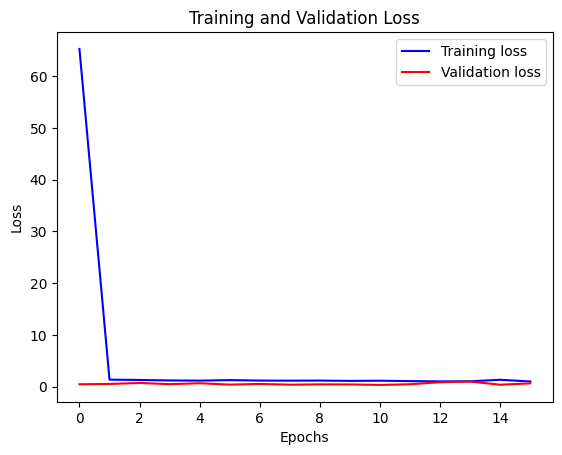

In [ ]:
def visualize_loss(history, title):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()


visualize_loss(history, "Training and Validation Loss")

It appears that the model is a good fit, as evidenced by the small gap between the training loss and validation loss. This indicates that the model is performing well.

In [ ]:
y_pred = baseline_model.predict(x_test)

y_pred = y_pred.flatten()
y_test = y_test.flatten()

5/5 [==============================] - 0s 4ms/step


In [ ]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred) * 100

print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"R²: {r2}")
print(f"MAPE: {mape}")

MAE: 0.7524042274012706
MSE: 1.1993299184947086
RMSE: 1.0951392233386168
R²: 0.9786573491348065
MAPE: 1.7349064066433173


The evaluation of the baseline model above indicates that it performs quite well in predicting the close price of CSCO stock. The MAE value of 0.7524 shows that the model's average prediction error is around 0.75 in stock price units. In 2020, the CSCO stock price was around 30 units, so an error of 0.75 translates to approximately a 2% error in the stock price. Therefore, improving this error would be beneficial, as it relates to stock prices.

The R² value of 0.9787 indicates that the model can explain about 97.87% of the variation in CSCO stock price data, which is very high and reflects a good model. Additionally, the MAPE value of 1.7349% suggests that the average relative error is around 1.73%, which is relatively low. Overall, the performance of this model is quite good. However, further reducing the error would be even better, as it concerns stock prices, which are important to many stakeholders.

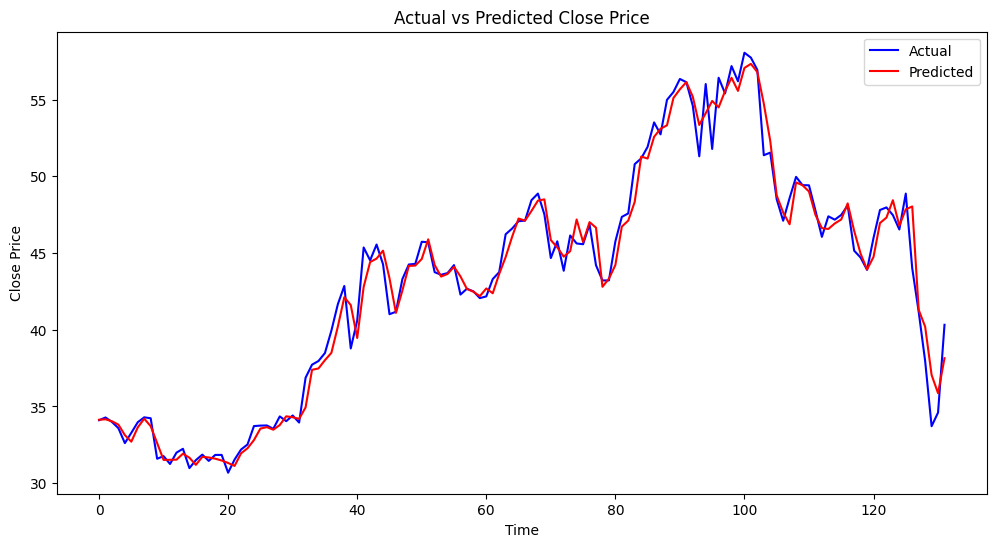

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(range(len(y_test)), y_test, color='blue', label='Actual')
plt.plot(range(len(y_pred)), y_pred, color='red', label='Predicted')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.title('Actual vs Predicted Close Price')
plt.legend()
plt.show()

Based on the plot above, the prediction results are very close to the actual close price, indicating good performance. However, there is still room for improvement when considering the evaluation metrics discussed earlier.

# Model 2 - Using Hyperparameter Tuning

Since the performance of the baseline model is already quite good, I chose to make modifications in the form of hyperparameter tuning. I am tuning the number of LSTM units within a range of 32 to 128, with a step of 32. Additionally, I am tuning the learning rate (1e-2, 1e-3, 1e-4).

In [ ]:
def build_model(hp):
    model = Sequential()
    model.add(LSTM(
        units=hp.Int('units', min_value=32, max_value=128, step=32),
        activation='relu',
        input_shape=(x_train.shape[1], 1)
    ))
    model.add(Dense(1))

    model.compile(
        optimizer=tf.keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
        loss='mean_squared_error'
    )

    return model

In [ ]:
tuner = kt.RandomSearch(build_model, objective='val_loss', max_trials=10,
                        executions_per_trial=3, directory='my_dir',
                        project_name='hyperparam_tuning')

tuner.search(train_data, epochs=50, validation_data=val_data, verbose=1)

Reloading Tuner from my_dir/hyperparam_tuning/tuner0.json


In [ ]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"Best number of units: {best_hps.get('units')}")
print(f"Best learning rate: {best_hps.get('learning_rate')}")

Best number of units: 32
Best learning rate: 0.01


The best hyperparameters obtained are 32 LSTM units and a learning rate of 0.01.

In [ ]:
best_model = tuner.hypermodel.build(best_hps)

In [ ]:
history = best_model.fit(train_data, validation_data = val_data,
                         epochs=100, verbose=1,
                         callbacks=[early_stopping, checkpoint])

Epoch 1/100
64/66 [============================>.] - ETA: 0s - loss: 15.7440
Epoch 1: val_loss did not improve from 0.30842
66/66 [==============================] - 3s 9ms/step - loss: 15.4546 - val_loss: 0.3972
Epoch 2/100
61/66 [==========================>...] - ETA: 0s - loss: 1.4059
Epoch 2: val_loss did not improve from 0.30842
66/66 [==============================] - 0s 4ms/step - loss: 1.3917 - val_loss: 1.1243
Epoch 3/100
64/66 [============================>.] - ETA: 0s - loss: 1.9461
Epoch 3: val_loss did not improve from 0.30842
66/66 [==============================] - 0s 4ms/step - loss: 1.9195 - val_loss: 0.7816
Epoch 4/100
51/66 [======================>.......] - ETA: 0s - loss: 1.9211
Epoch 4: val_loss did not improve from 0.30842
66/66 [==============================] - 0s 3ms/step - loss: 1.7237 - val_loss: 1.5081
Epoch 5/100
65/66 [============================>.] - ETA: 0s - loss: 1.1017
Epoch 5: val_loss did not improve from 0.30842
66/66 [============================

In [ ]:
y_pred = best_model.predict(x_test)

y_pred = y_pred.flatten()
y_test = y_test.flatten()

5/5 [==============================] - 0s 3ms/step


In [ ]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred) * 100

print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"R²: {r2}")
print(f"MAPE: {mape}")

MAE: 0.6755330779335713
MSE: 1.0544957159354442
RMSE: 1.026886418225231
R²: 0.9812347432036886
MAPE: 1.5566528927746677


For the tuned model, the results obtained are better compared to the baseline model, indicating the success of the modified model.

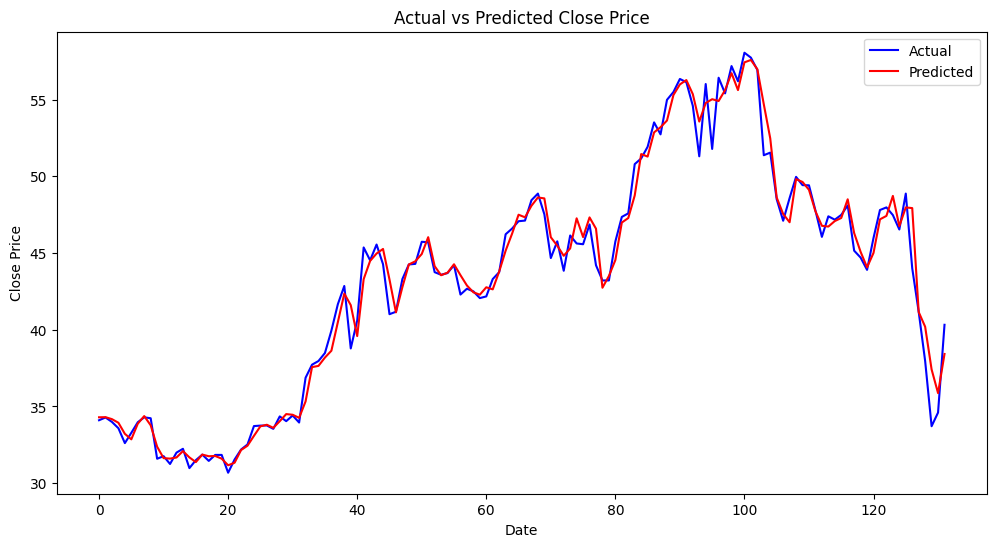

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(range(len(y_test)), y_test, color='blue', label='Actual')
plt.plot(range(len(y_pred)), y_pred, color='red', label='Predicted')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Actual vs Predicted Close Price')
plt.legend()
plt.show()

Based on the plot above, the prediction results are very close to the actual close price. When compared to the baseline model, there are no significant differences in the prediction plots. However, in terms of evaluation metrics, this modified model outperforms the baseline model.

# Evaluation & Conclusion

In [ ]:
def evaluate_model(model, x_test, y_test):

    predictions = model.predict(x_test)

    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    mae = mean_absolute_error(y_test, predictions)
    mape = mean_absolute_percentage_error(y_test, predictions) * 100

    return rmse, mae, mape

In [ ]:
baseline_rmse, baseline_mae, baseline_mape = evaluate_model(baseline_model, x_test, y_test)

tuned_rmse, tuned_mae, tuned_mape = evaluate_model(best_model, x_test, y_test)

5/5 [==============================] - 0s 3ms/step


In [ ]:
print("Baseline Model Evaluation:")
print(f"RMSE: {baseline_rmse}")
print(f"MAE: {baseline_mae}")
print(f"MAPE: {baseline_mape}%")

print("\nTuned Model Evaluation:")
print(f"RMSE: {tuned_rmse}")
print(f"MAE: {tuned_mae}")
print(f"MAPE: {tuned_mape}%")

Baseline Model Evaluation:
RMSE: 1.0951392233386168
MAE: 0.7524042274012706
MAPE: 1.7349064066433173%

Tuned Model Evaluation:
RMSE: 1.026886418225231
MAE: 0.6755330779335713
MAPE: 1.5566528927746677%


From the output above, it is clear that the modified model with hyperparameter tuning shows better performance in predicting the close price compared to the baseline model.

### Explanation of RMSE, MAE, and MAPE metrics:

- **RMSE** measures the square root of the average squared errors between predicted and actual values. The RMSE value for the tuned model is 1.0269, which is lower than the baseline model's RMSE of 1.0951. This indicates that the tuned model has smaller overall prediction errors, meaning it is more accurate in predicting the close price of CSCO stock.

- **MAE** represents the average of the absolute differences between predicted and actual values. The MAE for the tuned model is 0.6755, which is lower than the baseline model's MAE of 0.7524. This shows that the average prediction error of the tuned model is smaller, indicating that its predictions are consistently closer to the actual close price.

- **MAPE** measures the average percentage of absolute errors between predicted and actual values. The MAPE for the tuned model is 1.5567%, while the baseline model's MAPE is 1.7349%. This clearly indicates that the tuned model has a smaller relative error, demonstrating better performance in predicting the close price of CSCO stock in terms of percentage error.

The decrease in RMSE, MAE, and MAPE values indicates that the model modified through hyperparameter tuning is more accurate in predicting the close price of CSCO stock based on the provided data. This demonstrates that the hyperparameter tuning successfully enhanced the model's accuracy and reliability in the time series prediction of CSCO's close price.